https://www.inflearn.com/course/%ED%94%84%EB%A1%9C%EA%B7%B8%EB%9E%98%EB%A8%B8%EB%A5%BC-%EC%9C%84%ED%95%9C-%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5?inst=4aa5e302#curriculum

In [2]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import gym
import numpy as np
import random as rand

In [3]:
class Agent(object):
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        
        self.node_num = 12
        self.learning_rate = 0.001
        self.epochs_cnt = 5               
        self.model = self.build_model()        
        
        self.discount_rate = 0.97
        self.penalty = -100

        self.episode_num = 500        
        
        self.replay_memory_limit = 2048
        self.replay_size = 32
        self.replay_memory = []

        self.epsilon = 0.99
        self.epsilon_decay = 0.2 # 0.2 episode의 20%가되면 수행되면  epsilon이 0이 된다.
        self.epsilon_min = 0.05
        
        self.moving_avg_size = 20
        self.reward_list= []
        self.count_list = []
        self.moving_avg_list = []
        
    def build_model(self):
        input_states = Input(shape=(1,self.state_size), name='input_states')
        x = (input_states)
        x = Dense(self.node_num, activation='relu')(x)
        out_actions = Dense(self.action_size, activation='linear', name='output')(x)
        model = tf.keras.models.Model(inputs=[input_states], outputs=[out_actions])
        model.compile(optimizer=Adam(learning_rate=self.learning_rate),
                      loss='mean_squared_error'
                     )
        model.summary()
        return model

    def train(self):
        for episode in range(self.episode_num):
            print(episode)
            state = self.env.reset()
            state = state[0] #최초 dictionary 형태 생성
            Q, count, reward_tot = self.take_action_and_append_memory(episode, state)

            if count < 500:
                reward_tot = reward_tot-self.penalty

            self.reward_list.append(reward_tot)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list,self.moving_avg_size))                
            
            self.train_mini_batch(Q)
                
            if(episode % 10 == 0):
                print("episode:{}, moving_avg:{}, rewards_avg:{}".format(episode, self.moving_avg_list[-1], np.mean(self.reward_list)))
        self.save_model()

    def take_action_and_append_memory(self, episode, state):
        reward_tot = 0
        count = 0
        done = False
        episilon = self.get_episilon(episode)
        while not done:
            count+=1
            state_t = np.reshape(state,[1, 1, self.state_size])
            Q = self.model.predict(state_t)
            action = self.greed_search(episilon, episode, Q)
            state_next, reward, done, none, none2 = self.env.step(action) #2022.12.10 gym version upgrade 후 return 값 5개로 변경
            
            if done:
                reward = self.penalty 
            self.replay_memory.append([state_t, action, reward, state_next, done])
            if len(self.replay_memory) > self.replay_memory_limit:
                del self.replay_memory[0]
            reward_tot += reward
            state = state_next
        return Q, count, reward_tot

    def train_mini_batch(self, Q):
        array_state = []
        array_Q = []
        this_replay_size = self.replay_size
        if len(self.replay_memory) < self.replay_size:
            this_replay_size = len(self.replay_memory)
        
        for sample in rand.sample(self.replay_memory, this_replay_size):
            state_t,action,reward,state_next,done = sample
            if done:
                Q[0, 0, action] = reward
            else:
                state_t= np.reshape(state_next,[1,1,self.state_size])
                Q_new = self.model.predict(state_t)
                Q[0, 0, action] = reward + self.discount_rate * np.max(Q_new)
            array_state.append(state_t.reshape(1,self.state_size))
            array_Q.append(Q.reshape(1,self.action_size))
        array_state_t = np.array(array_state)
        array_Q_t = np.array(array_Q)
        hist = self.model.fit(array_state_t, array_Q_t, epochs=self.epochs_cnt, verbose=0)    

    def get_episilon(self, episode):
        result = self.epsilon * ( 1 - episode/(self.episode_num*self.epsilon_decay) )
        if result < self.epsilon_min:
            result = self.epsilon_min
        return result

    def greed_search(self, episilon, episode, Q):  
        if episilon > np.random.rand(1):
            action = self.env.action_space.sample()
        else:
            action = np.argmax(Q)
        return action

    def moving_avg(self, data, size=10):
        if len(data) > size:
            c = np.array(data[len(data)-size:len(data)]) 
        else:
            c = np.array(data) 
        return np.mean(c)
    
    def save_model(self):
        self.model.save("./model/dqn")
        print("*****end learing")

##모델 학습에 500epoch에 30분 정도 걸림

In [4]:
if __name__ == "__main__":
    agent = Agent()
    agent.train()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_states (InputLayer)   [(None, 1, 4)]            0         
                                                                 
 dense (Dense)               (None, 1, 12)             60        
                                                                 
 output (Dense)              (None, 1, 2)              26        
                                                                 
Total params: 86 (344.00 Byte)
Trainable params: 86 (344.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
0
1/1 [==============================] - 0s 54ms/step


C:\Users\cbrnt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


1/1 [==============================] - 0s 41ms/step

episode:0, moving_avg:17.0, rewards_avg:16.0
1
1/1 [==============================] - 0s 35ms/step
2
1/1 [==============================] - 0s 37ms/step
3
1/1 [==============================] - 0s 64ms/step
4
1/1 [==============================] - 0s 54ms/step
5
1/1 [==============================] - 0s 60ms/step
6
1/1 [==============================] - 0s 51ms/step
7
1/1 [==============================] - 0s 49ms/step
8
1/1 [==============================] - 0s 36ms/step


KeyboardInterrupt: 

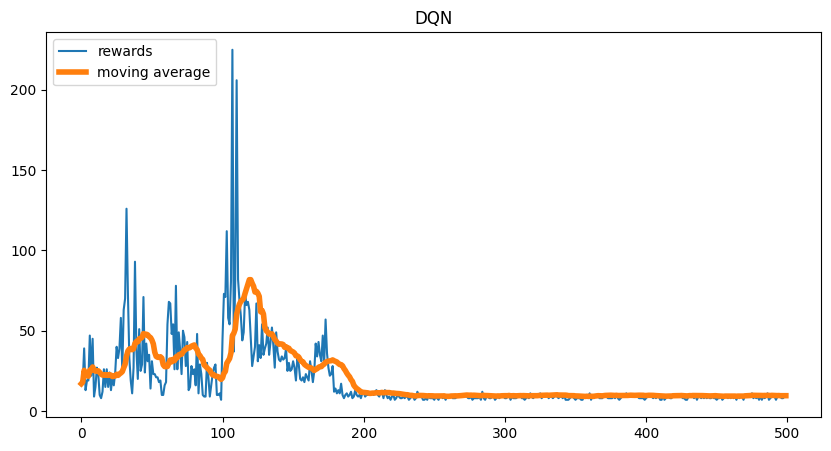

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label='rewards')
plt.plot(agent.moving_avg_list, linewidth=4, label='moving average')
plt.legend(loc='upper left')
plt.title('DQN')
plt.show()

In [ ]:
def run_agent(agent):
    state = agent.env.reset()
    done = False
    total_reward = 0

    while not done:
        state_array = state[0]  # 튜플에서 배열을 추출
        state_t = np.reshape(state_array, [1, 1, 4])  # 모델의 입력 형태에 맞게 reshape
        Q = agent.model.predict(state_t)
        action = np.argmax(Q)
        
        # env.step(action)의 반환 값 확인
        step_result = agent.env.step(action)
        
        if len(step_result) == 5:
            next_state, reward, done, _, _ = step_result
        else:
            raise ValueError("Unexpected number of values returned by env.step(action)")

        total_reward += reward
        agent.env.render()  # CartPole 환경을 시각화하려면 추가

    print("Total Reward:", total_reward)
    agent.env.close()

# Agent 인스턴스 생성
agent = Agent()

# 저장된 모델 로드
agent.model = tf.keras.models.load_model("./model/dqn")

# 에이전트 실행
run_agent(agent)


Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_states (InputLayer)   [(None, 1, 4)]            0         
                                                                 
 dense_26 (Dense)            (None, 1, 12)             60        
                                                                 
 output (Dense)              (None, 1, 2)              26        
                                                                 
Total params: 86 (344.00 Byte)
Trainable params: 86 (344.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [==============================] - ETA: 0s

C:\Users\cbrnt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\gym\envs\classic_control\cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


1/1 [==============================] - 0s 27ms/step
Total Reward: 9.0


In [ ]:
import gym
env = gym.make('CartPole-v1')
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

In [2]:
import gym
from collections import deque as dq
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# NN를 학습시키기 위한 hyperparameter
learning_rate = 0.0005
batch_size = 32

# 감마는 할인율이라고 부르는 값으로, 미래가치에 대한 중요도를 조절합니다.
# 클수록 미래에 받을 보상에 더 큰 가치를 두는 것.
gamma = 0.98

buffer_limit = 50000

In [3]:
# 강화학습은 Training data set이라는게 따로 없습니다. Agent가 행동을 취하고 데이터셋을 쌓아나가야합니다.
# 그 데이터셋을 쌓기 위한 버퍼
class ReplayBuffer():
    def __init__(self):
        self.buffer = dq(maxlen=buffer_limit)
    
    # 버퍼에는 (state, action ,reward, nstate, done) 값이 들어갑니다.
    def put(self, transition):
        self.buffer.append(transition)
    
    # 샘플 함수를 만드는 이유는 버퍼에 쌓인 데이터셋에서 랜덤으로 학습을 시키기 위함입니다.
    # 그냥 연속해서 쌓인 n개의 데이터셋을 그대로 사용하면 데이터간의 상관관계가 너무 크기 때문에 학습이 잘 안됩니다.
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)

In [4]:
# cartpole의 state가 4개고 action은 2개이기 때문에 input 4, output 2인 NN생성
# 2층짜리 NN입니다. 임의로 설계했습니다.
class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    # epsilon greedy 전략을 사용합니다.
    # 간단하게 설명하면 탐험이라는 개념을 통해서 가보지 않은 경로를 가볼 수 있게 해줍니다.
    def sample_action(self, observation, epsilon):
        out = self.forward(observation)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else : 
            return out.argmax().item()

In [5]:
def train(q, q_target, memory, optimizer):
    for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)
        
        # 벨만함수로부터 유도된 DQN 비용함수를 구현 학습시킵니다.
        q_out = q(s)
        q_a = q_out.gather(1,a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
# gym을 통한 CartPole env 생성
env = gym.make('CartPole-v1')
# Double Deep Q Learning 개념
# target_net을 semi constant로 사용
q = Qnet()
q_target = Qnet()
q_target.load_state_dict(q.state_dict())
memory = ReplayBuffer()

print_interval = 20
score = 0.0  
optimizer = optim.Adam(q.parameters(), lr=learning_rate)

for n_epi in range(500):
    epsilon = max(0.01, 0.08 - 0.01*(n_epi/200)) #Linear annealing from 8% to 1%
    s = env.reset()
    done = False

    while not done:
        print(s)
        print("a")
        print(s[0])
        break

        # a = q.sample_action(torch.from_numpy(s[0]).float(), epsilon)
        # s_prime, r, done, info = env.step(a)
        # done_mask = 0.0 if done else 1.0
        # memory.put((s,a,r/100.0,s_prime, done_mask))
        # s = s_prime

        # score += r
        # if done:
        #     break
    
    # 메모리가 어느정도 차야 random sample이 가능하기 때문에 일정 이상 차면 학습을 진행
    if memory.size()>2000:
        train(q, q_target, memory, optimizer)

    if n_epi%print_interval==0 and n_epi!=0:
        # 일정 주기마다 semi constant인 target-net도 업데이트.
        q_target.load_state_dict(q.state_dict())
        print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
                                                        n_epi, score/print_interval, memory.size(), epsilon*100))
        score = 0.0
env.close()

(array([-0.00438327, -0.03805203,  0.00687305,  0.0254702 ], dtype=float32), {})


TypeError: expected np.ndarray (got tuple)

: 

In [43]:
state = env.reset()
state = torch.tensor(state, dtype=torch.float)
done = False

for i in range(500+1):

    if done:
        env.render()
        env.step(action)
    else:
        env.render()
        # 이부분이 위에서 학습한 모델에 state를 넣어서 취해야 하는 action을 받는 부분입니다.
        action = q.forward(state).argmax().item()
        
        state, reward, done, info = env.step(action)
        state = torch.tensor(state, dtype=torch.float)
        # print(state, done)

        if done or i==500:
            print(i)

env.close()

C:\Users\cbrnt\AppData\Local\Temp\ipykernel_23032\3833757869.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  state = torch.tensor(state, dtype=torch.float)


ValueError: expected sequence of length 4 at dim 1 (got 0)